<a href="https://colab.research.google.com/github/NguyenSang2003/ProjectDataMining/blob/main/Project_Datamining_Nhom_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Data Mining - Phân loại nhị phân nấm ăn được và độc bằng cách sử dụng dữ liệu Mushroom


In [20]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/DataMining/Project'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/DataMining/Project


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

#Load the dataset mushrooms

In [22]:
# load dataset
ds1 = pd.read_csv('mushrooms.csv')
ds1.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


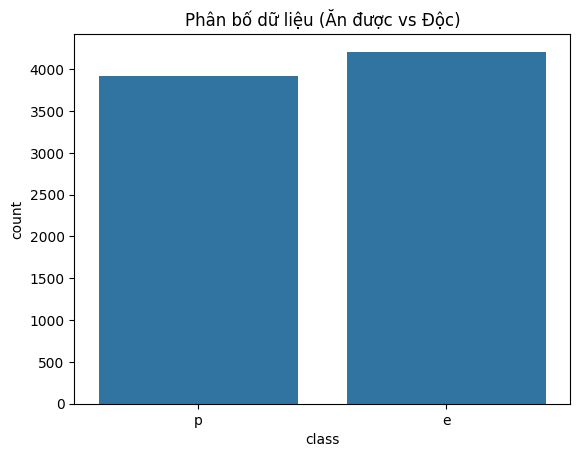

Số lượng ăn được: 4208, Số lượng độc: 3916
Tỷ lệ độc: 48.20%


<ipython-input-23-d4f8ac74b30e>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Số lượng ăn được: {class_counts[0]}, Số lượng độc: {class_counts[1]}")
<ipython-input-23-d4f8ac74b30e>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Tỷ lệ độc: {class_counts[1] / sum(class_counts):.2%}")


In [23]:
# Kiểm tra phân bố nhãn
sns.countplot(x='class', data=ds1)
plt.title('Phân bố dữ liệu (Ăn được vs Độc)')
plt.show()

# Kiểm tra imbalance
class_counts = ds1['class'].value_counts()
print(f"Số lượng ăn được: {class_counts[0]}, Số lượng độc: {class_counts[1]}")
print(f"Tỷ lệ độc: {class_counts[1] / sum(class_counts):.2%}")

In [24]:
# kiểm tra lại xem có giá trị '?' trong cột 'stalk-root' không
print(ds1['stalk-root'].value_counts())

stalk-root
b    3776
?    2480
e    1120
c     556
r     192
Name: count, dtype: int64


In [25]:
# Thay giá trị '?' bằng 'unknown'
ds1['stalk-root'] = ds1['stalk-root'].replace('?', 'unknown')

In [26]:
# Tối ưu hóa mã hóa dữ liệu
ds1_encoded = pd.get_dummies(ds1, drop_first=True)

In [27]:
# Tiền xử lý dữ liệu
# Mã hóa các cột từ dạng chữ thành dạng số
label_encoders = {}
for column in ds1.columns:
    le = LabelEncoder()
    ds1[column] = le.fit_transform(ds1[column])
    label_encoders[column] = le

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X = ds1.drop('class', axis=1)
y = ds1['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Định nghĩa hàm hiển thị kết quả
def display_results(model_name, y_true, y_pred):
    print(f"\n=== Kết quả cho mô hình: {model_name} ===")
    print("Báo cáo phân loại:")
    print(classification_report(y_true, y_pred, target_names=['Ăn được', 'Độc']))
    print("Ma trận nhầm lẫn:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ăn được', 'Độc'], yticklabels=['Ăn được', 'Độc'])
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title(f"Ma trận nhầm lẫn: {model_name}")
    plt.show()
    print(f"Độ chính xác: {accuracy_score(y_true, y_pred):.2f}")

In [28]:
from sklearn.model_selection import GridSearchCV

# Grid Search cho Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


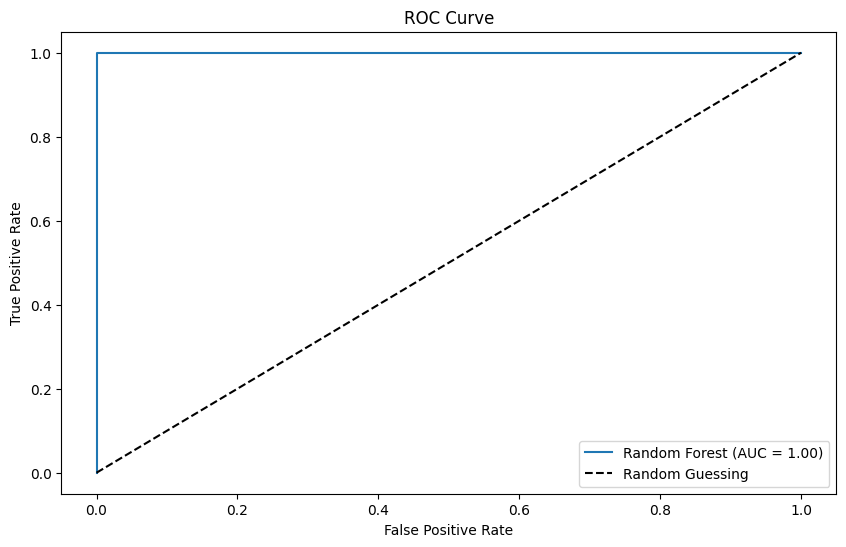

In [29]:
# Tính ROC và AUC cho Random Forest
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Vẽ đồ thị ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


=== Kết quả cho mô hình: Naive Bayes ===
Báo cáo phân loại:
              precision    recall  f1-score   support

     Ăn được       0.93      0.94      0.93      1257
         Độc       0.94      0.92      0.93      1181

    accuracy                           0.93      2438
   macro avg       0.93      0.93      0.93      2438
weighted avg       0.93      0.93      0.93      2438

Ma trận nhầm lẫn:


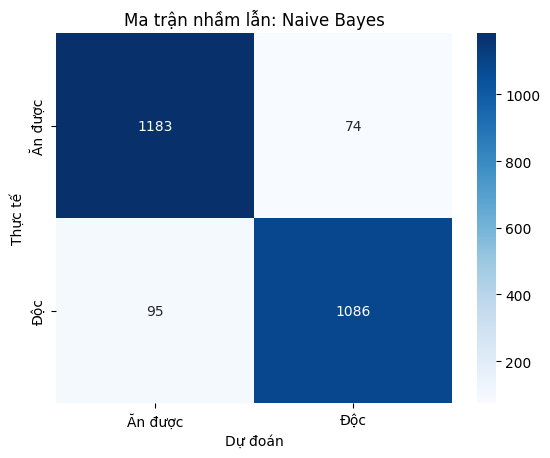

Độ chính xác: 0.93

=== Kết quả cho mô hình: Hồi quy Logistic ===
Báo cáo phân loại:
              precision    recall  f1-score   support

     Ăn được       0.95      0.95      0.95      1257
         Độc       0.95      0.95      0.95      1181

    accuracy                           0.95      2438
   macro avg       0.95      0.95      0.95      2438
weighted avg       0.95      0.95      0.95      2438

Ma trận nhầm lẫn:


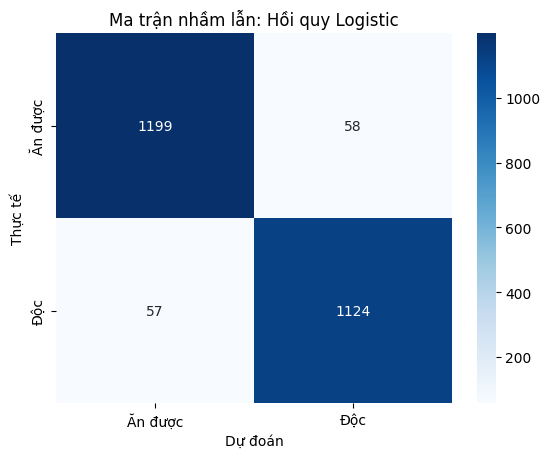

Độ chính xác: 0.95

=== Kết quả cho mô hình: LDA ===
Báo cáo phân loại:
              precision    recall  f1-score   support

     Ăn được       0.94      0.95      0.95      1257
         Độc       0.95      0.94      0.94      1181

    accuracy                           0.95      2438
   macro avg       0.95      0.95      0.95      2438
weighted avg       0.95      0.95      0.95      2438

Ma trận nhầm lẫn:


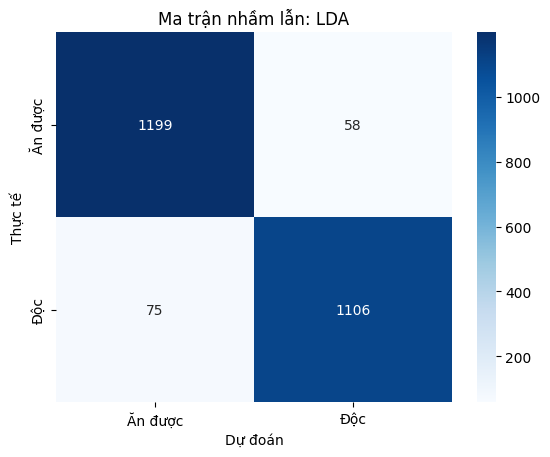

Độ chính xác: 0.95

=== Kết quả cho mô hình: Random Forest ===
Báo cáo phân loại:
              precision    recall  f1-score   support

     Ăn được       1.00      1.00      1.00      1257
         Độc       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Ma trận nhầm lẫn:


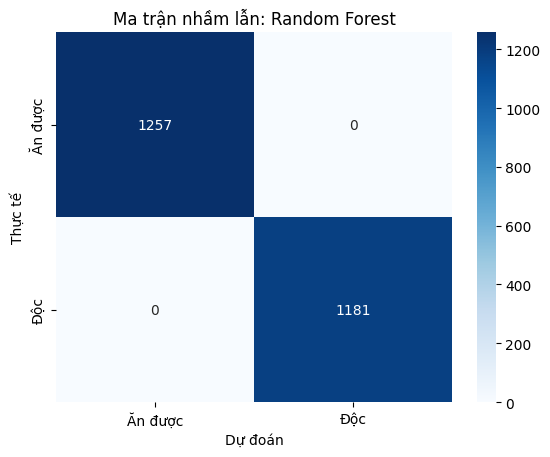

Độ chính xác: 1.00

=== Bảng tổng hợp kết quả ===
            Mô hình  Độ chính xác
0       Naive Bayes      0.930681
1  Hồi quy Logistic      0.952830
2               LDA      0.945447
3     Random Forest      1.000000


In [30]:
# Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
display_results("Naive Bayes", y_test, y_pred_nb)

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
display_results("Hồi quy Logistic", y_test, y_pred_lr)

# Linear Discriminant Analysis (LDA)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train, y_train)
y_pred_lda = model_lda.predict(X_test)
display_results("LDA", y_test, y_pred_lda)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
display_results("Random Forest", y_test, y_pred_rf)

# Bảng tổng hợp kết quả
models = ['Naive Bayes', 'Hồi quy Logistic', 'LDA', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_lda),
    accuracy_score(y_test, y_pred_rf)
]
results_df = pd.DataFrame({'Mô hình': models, 'Độ chính xác': accuracies})
print("\n=== Bảng tổng hợp kết quả ===")
print(results_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   class                     8124 non-null   int64
 1   cap-shape                 8124 non-null   int64
 2   cap-surface               8124 non-null   int64
 3   cap-color                 8124 non-null   int64
 4   bruises                   8124 non-null   int64
 5   odor                      8124 non-null   int64
 6   gill-attachment           8124 non-null   int64
 7   gill-spacing              8124 non-null   int64
 8   gill-size                 8124 non-null   int64
 9   gill-color                8124 non-null   int64
 10  stalk-shape               8124 non-null   int64
 11  stalk-root                8124 non-null   int64
 12  stalk-surface-above-ring  8124 non-null   int64
 13  stalk-surface-below-ring  8124 non-null   int64
 14  stalk-color-above-ring    8124 non-null 

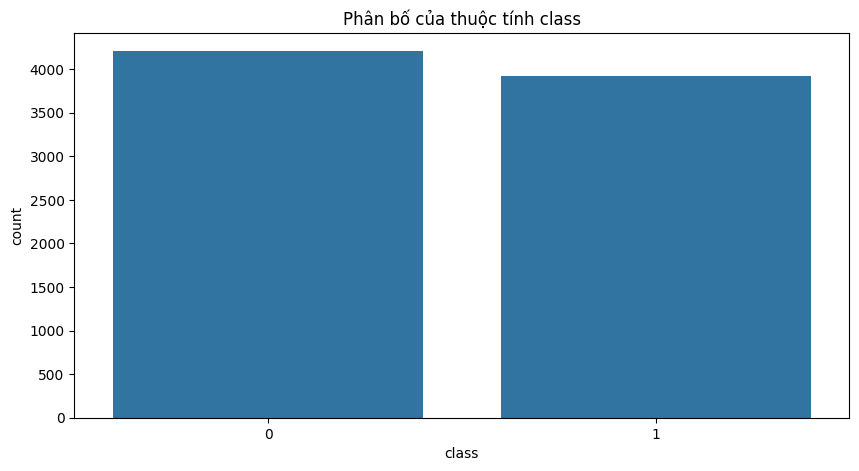

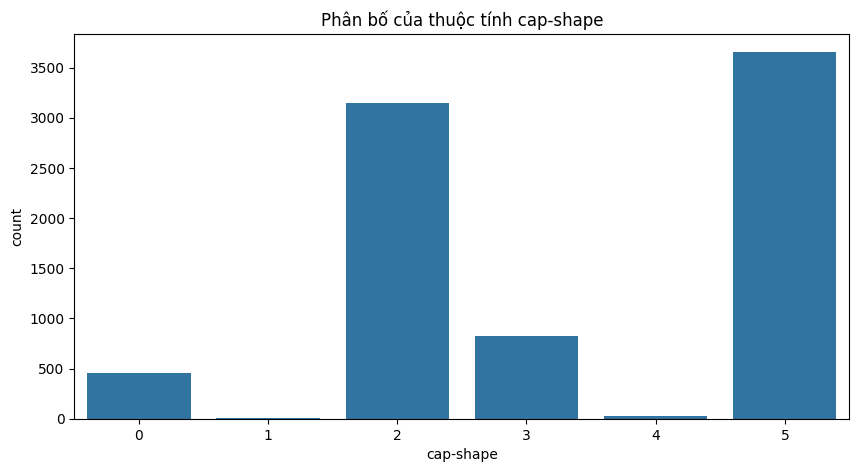

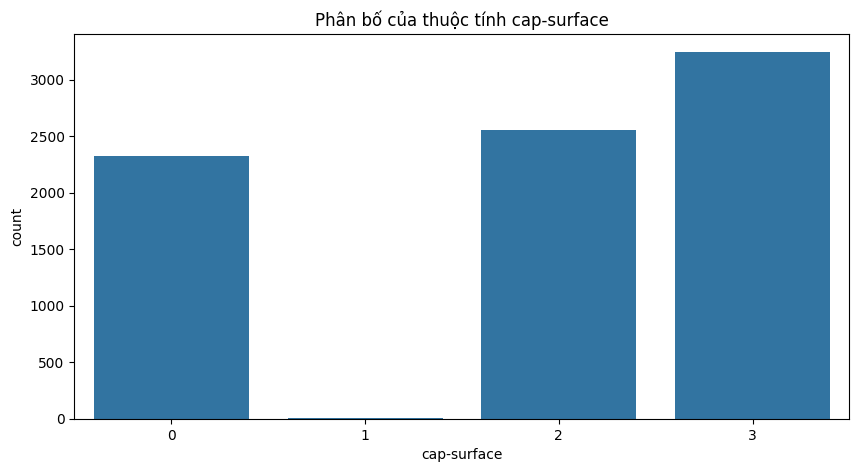

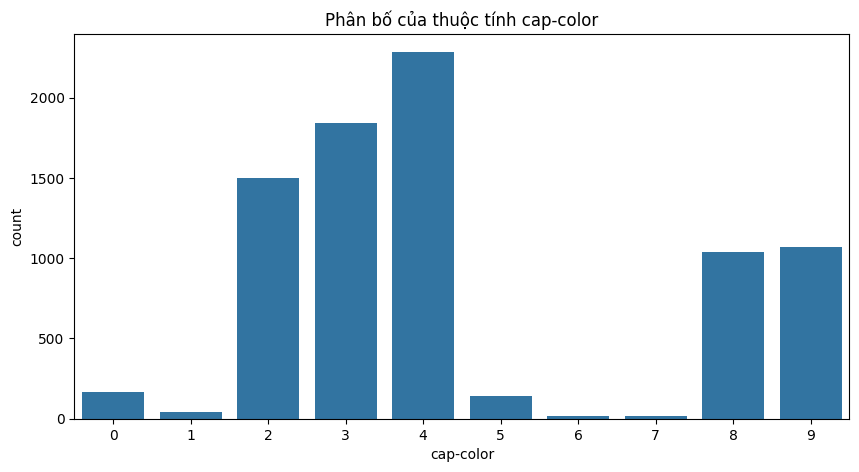

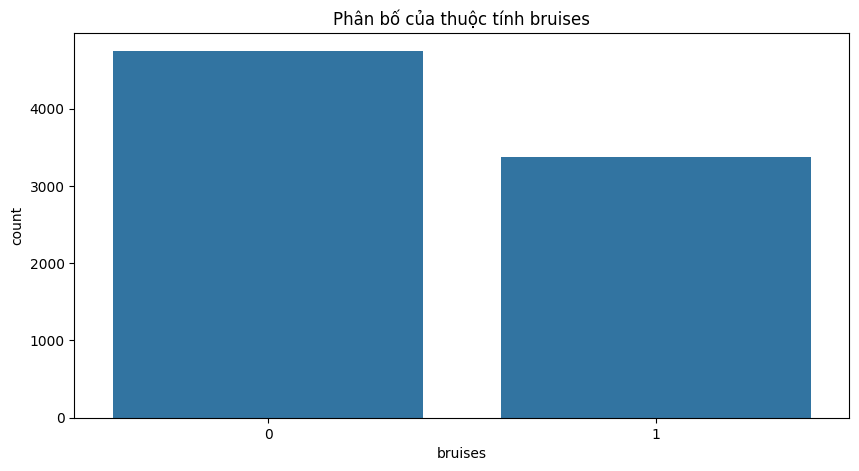

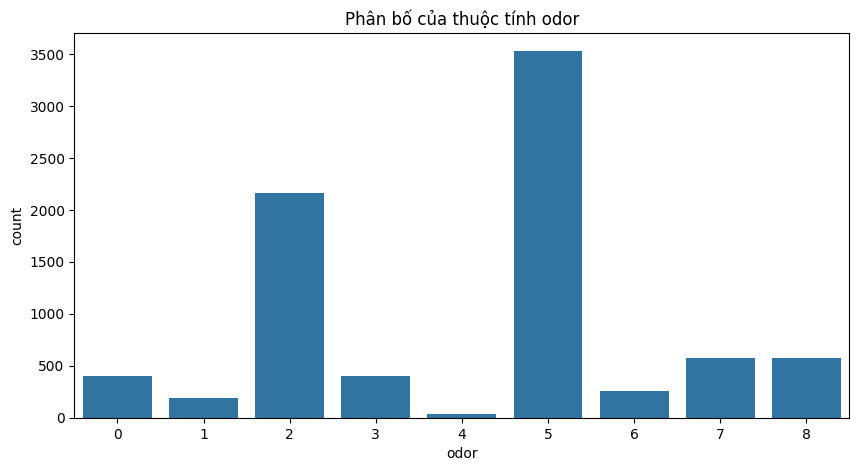

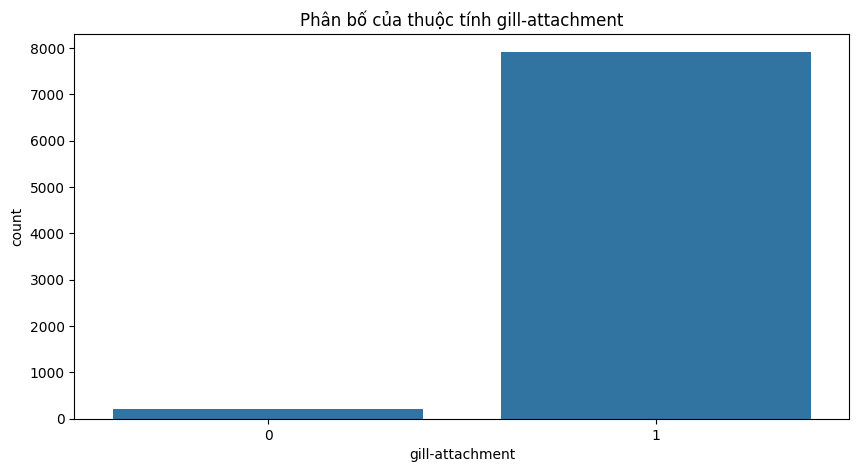

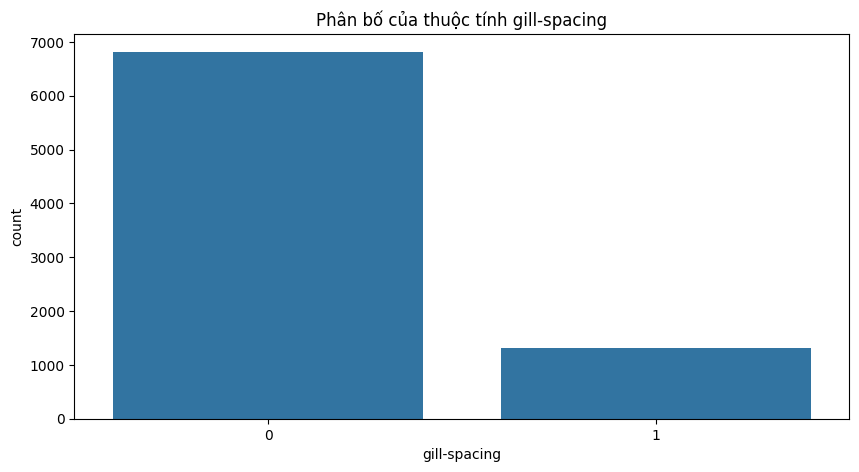

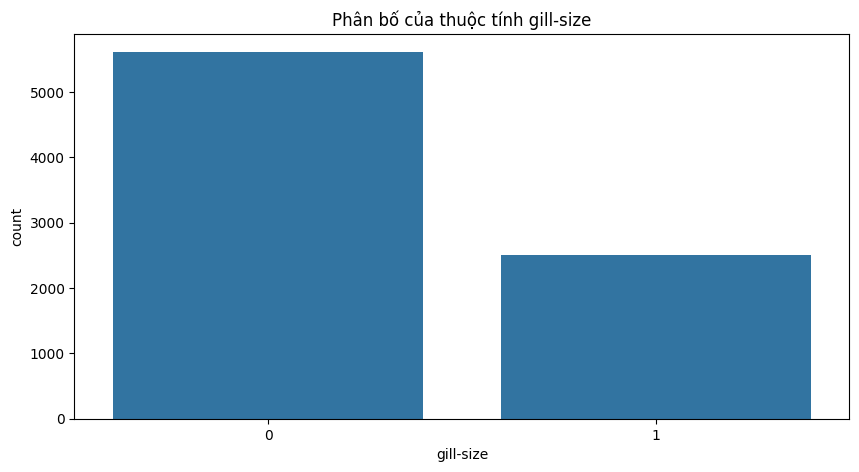

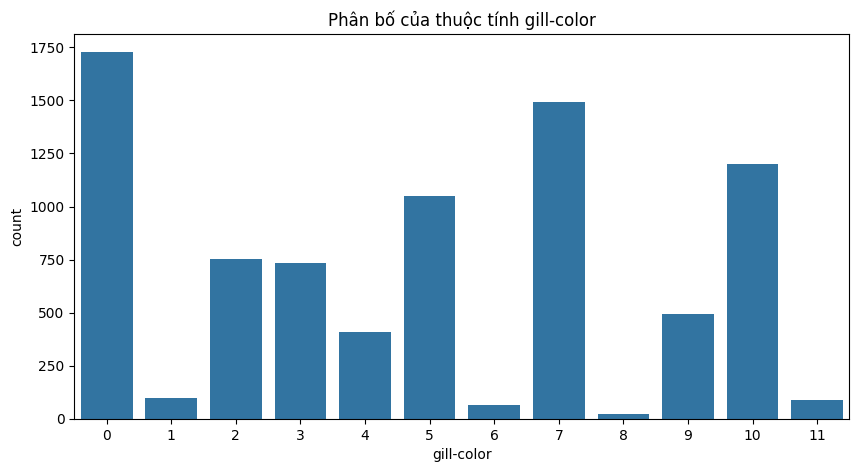

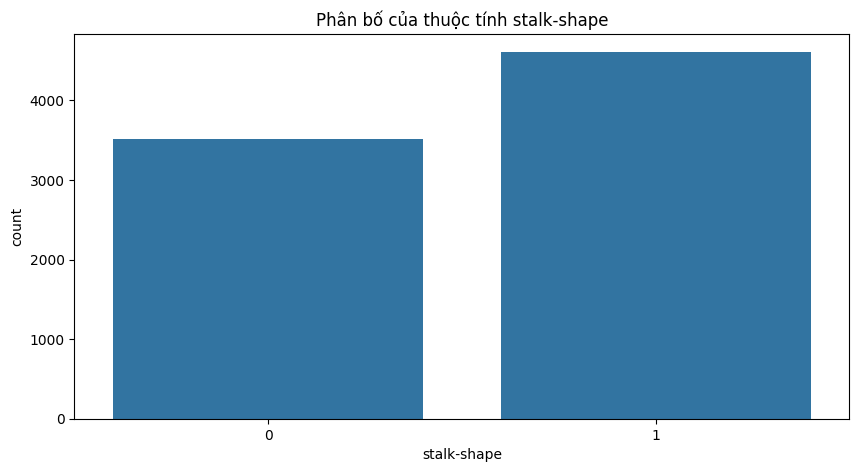

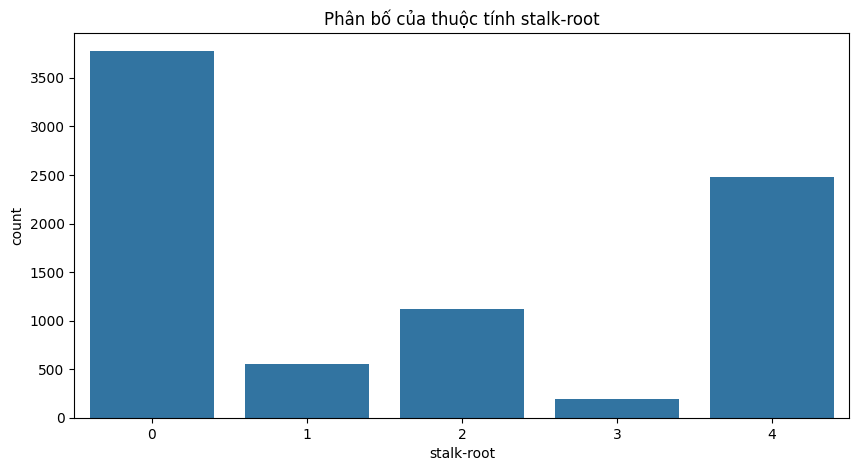

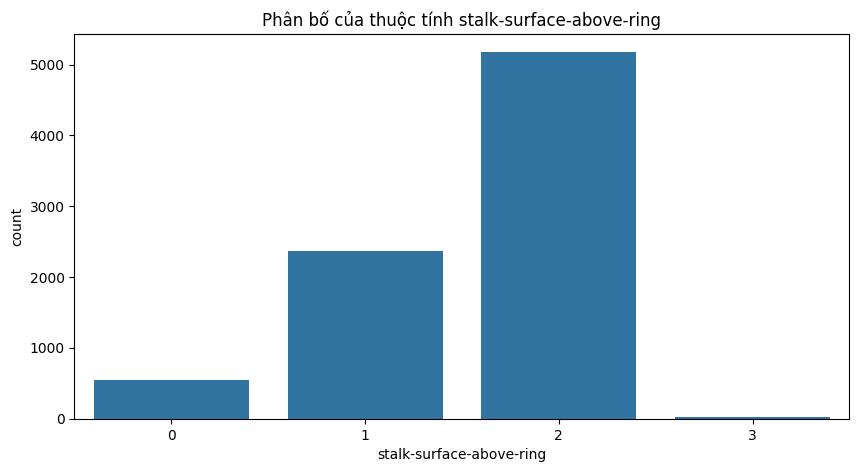

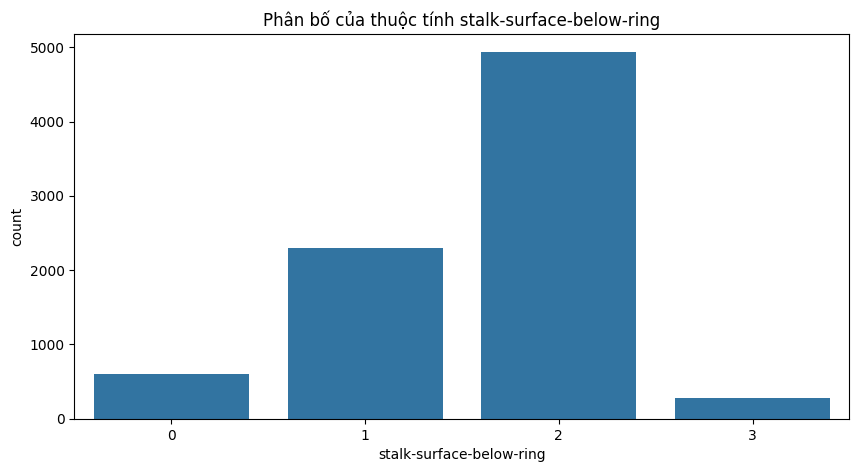

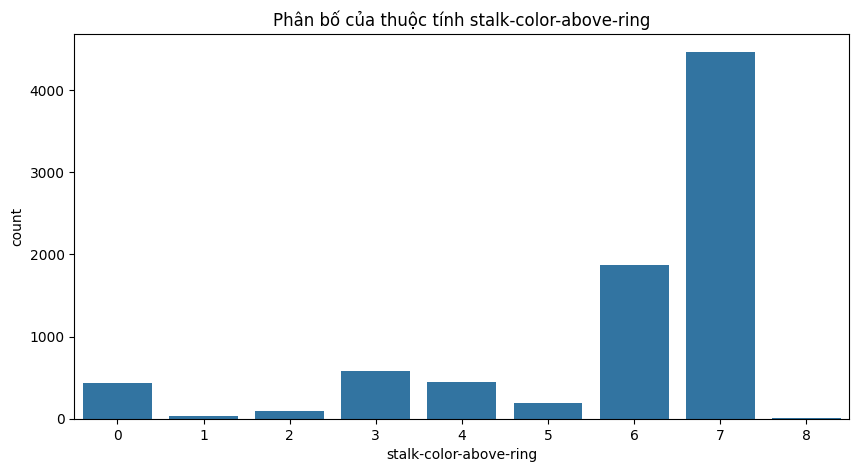

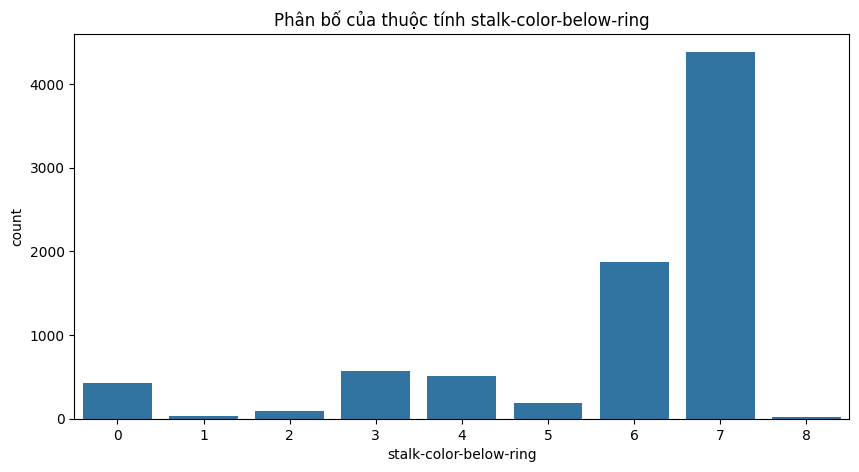

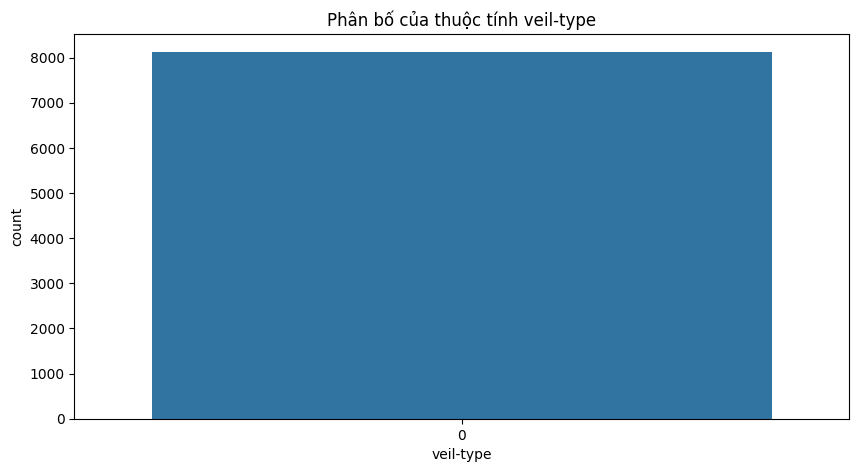

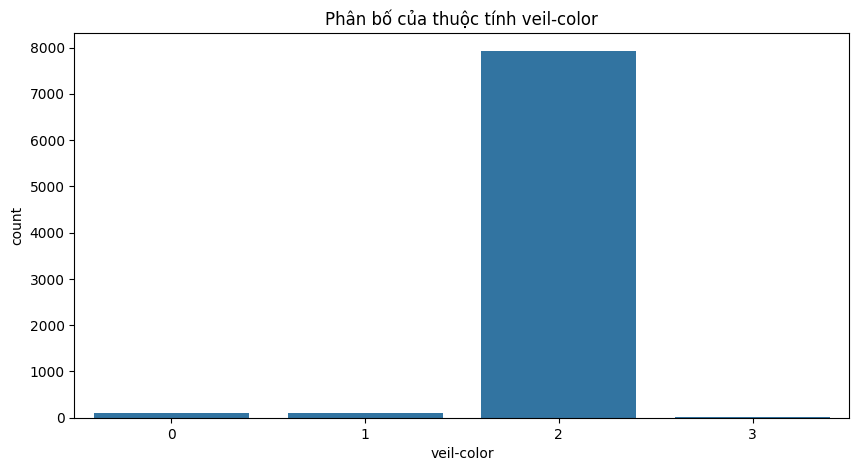

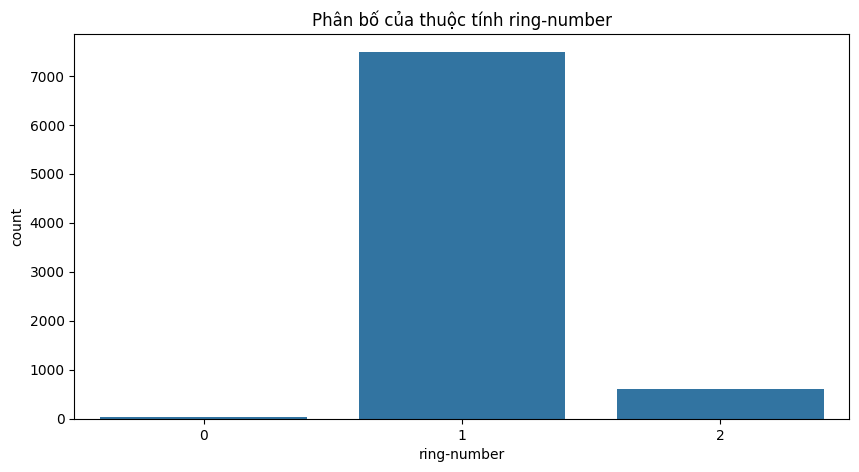

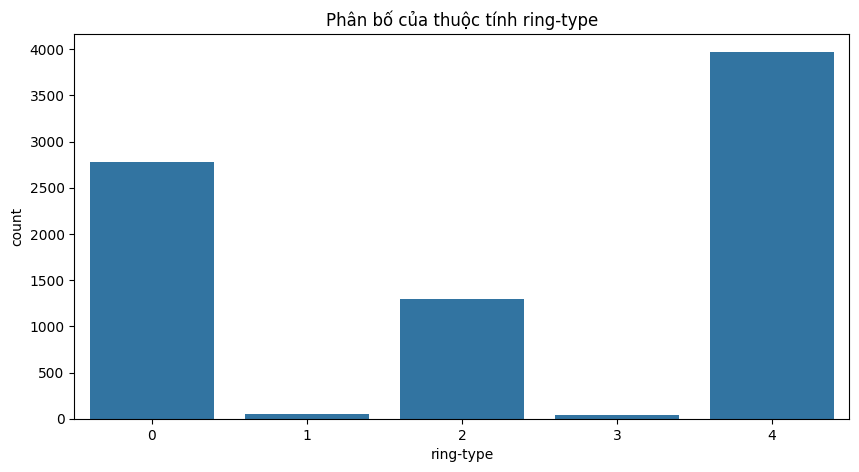

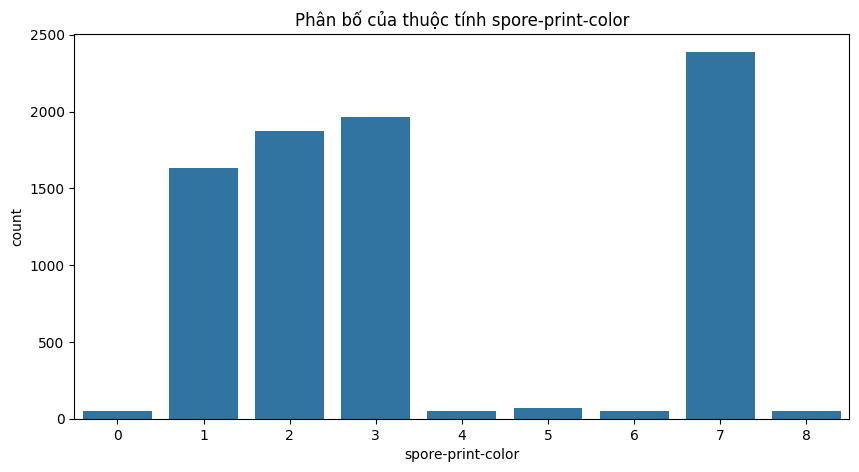

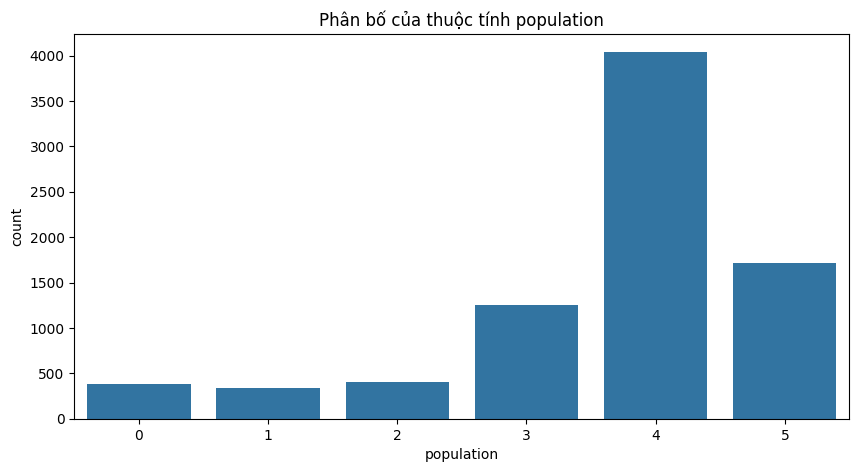

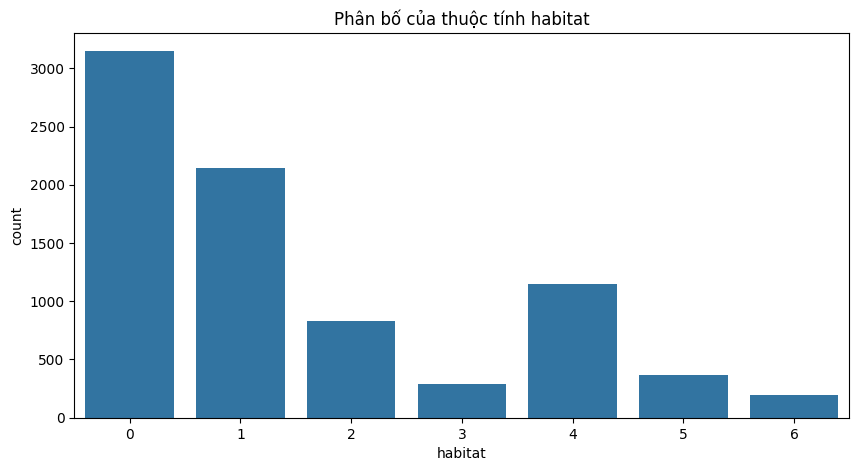

In [31]:
# Mô tả dữ liệu
print(ds1.info())
print(ds1.describe())

# Vẽ biểu đồ phân bố dữ liệu
for column in ds1.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, data=ds1)
    plt.title(f'Phân bố của thuộc tính {column}')
    plt.show()



---
# End of Project.
# Done by: 21130512 - Nguyễn Văn Sáng

